In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2025-08-12 08:12:03.973893: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754986324.324665      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754986324.423771      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Train: (60000, 784) (60000,)
Test: (10000, 784) (10000,)
normalized_images shape:- (5923, 64)
shape 1:- (5923, 64, 64)
shape 2:- (5923, 64, 64)
shape 3:- (5923, 64, 64)
shape 4:- (5923, 64, 64)


/tmp/ipykernel_36/4060289583.py:138: RuntimeWarning: invalid value encountered in divide
  density4 /= np.linalg.norm(density4, axis=(1,2), keepdims=True)


normalized_images shape:- (6742, 64)
shape 1:- (6742, 64, 64)
shape 2:- (6742, 64, 64)
shape 3:- (6742, 64, 64)
shape 4:- (6742, 64, 64)
normalized_images shape:- (5958, 64)
shape 1:- (5958, 64, 64)
shape 2:- (5958, 64, 64)
shape 3:- (5958, 64, 64)
shape 4:- (5958, 64, 64)
normalized_images shape:- (6131, 64)
shape 1:- (6131, 64, 64)
shape 2:- (6131, 64, 64)
shape 3:- (6131, 64, 64)
shape 4:- (6131, 64, 64)
normalized_images shape:- (5842, 64)
shape 1:- (5842, 64, 64)
shape 2:- (5842, 64, 64)
shape 3:- (5842, 64, 64)
shape 4:- (5842, 64, 64)
normalized_images shape:- (5421, 64)
shape 1:- (5421, 64, 64)
shape 2:- (5421, 64, 64)
shape 3:- (5421, 64, 64)
shape 4:- (5421, 64, 64)
normalized_images shape:- (5918, 64)
shape 1:- (5918, 64, 64)
shape 2:- (5918, 64, 64)
shape 3:- (5918, 64, 64)
shape 4:- (5918, 64, 64)
normalized_images shape:- (6265, 64)
shape 1:- (6265, 64, 64)
shape 2:- (6265, 64, 64)
shape 3:- (6265, 64, 64)
shape 4:- (6265, 64, 64)
normalized_images shape:- (5851, 64)
shap

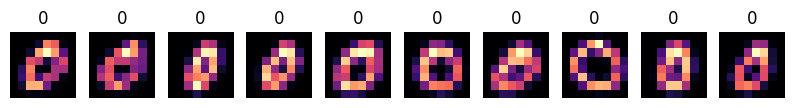

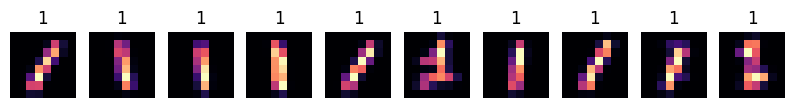

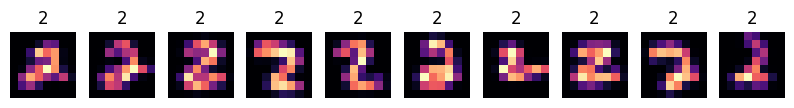

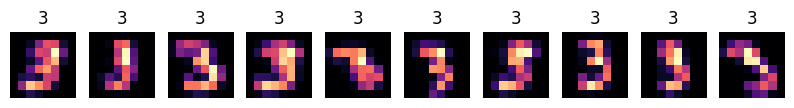

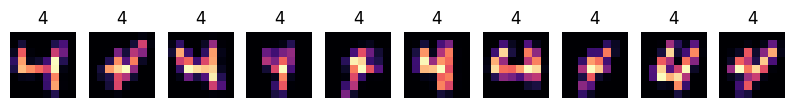

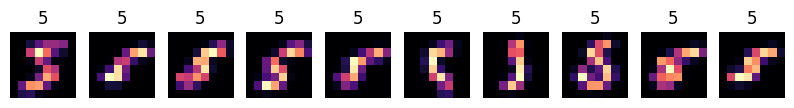

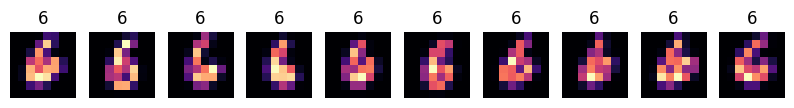

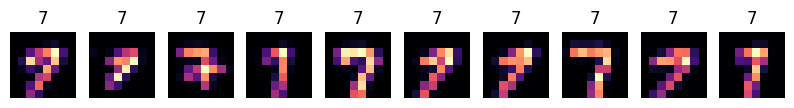

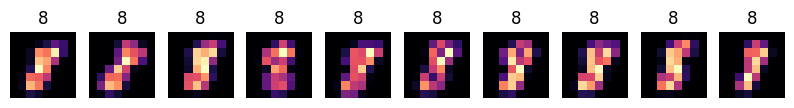

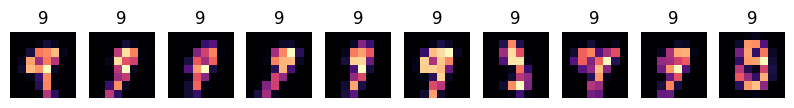

normalized_Hermitian_Digit_matrices shape:- torch.Size([60000, 64, 64])
normalized_hermitian_matrices_test_input shape:- torch.Size([10000, 64, 64])
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [1]:
# Data Preprocessing of the MNIST Dataset to produce the train and test normalized Hamiitonians...
# We can construct the hamiltonians from the four methods described in the paper...
import numpy as np
from skimage.transform import resize
import matplotlib.pyplot as plt
from PIL import Image
import torch
from sklearn.datasets import fetch_openml
import scipy

# ----------------------------
# Load MNIST from OpenML
# ----------------------------
# mnist = fetch_openml('mnist_784', version=1, as_frame=False)

# mnist_images = mnist.data.astype(np.float64)   # (70000, 784)
# mnist_labels = mnist.target.astype(int)        # (70000,)

# x_train = mnist_images[:60000]
# y_train = mnist_labels[:60000]
# x_test  = mnist_images[60000:60201]
# y_test  = mnist_labels[60000:60201]

#OR

from tensorflow.keras.datasets import mnist

# Load MNIST using Keras
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# # Reshape and convert to float64 for consistency
x_train = x_train.reshape(-1, 784).astype(np.float64)
x_test = x_test.reshape(-1, 784).astype(np.float64)
print("Train:", x_train.shape, y_train.shape)
print("Test:", x_test.shape, y_test.shape)

# ----------------------------
# Helper functions
# ----------------------------
def separate_digits(images, labels):
    """Group images by digit label."""
    digit_image = {d: [] for d in range(10)}
    for img, lbl in zip(images, labels):
        digit_image[lbl].append(img)
    return digit_image

def resize_images_batch(images, new_size=(8, 8), batch_size=500):
    """Resize a batch of flattened 28x28 images to new_size."""
    n = len(images)
    resized = []
    for i in range(0, n, batch_size):
        batch = images[i:i+batch_size]
        resized_batch = [resize(img.reshape(28,28), new_size).flatten() for img in batch]
        resized.extend(resized_batch)
    return np.array(resized)

def normalize_batch(images):
    """Normalize each image vector."""
    norms = np.linalg.norm(images, axis=1, keepdims=True)
    return images / norms

#Creating Hamiltonian using outer product method
def density_matrix_batch(images):
    """Convert vectors to density matrices."""
    return np.matmul(images[:,:,np.newaxis], images[:,np.newaxis,:])

#Creating the Hamiltonian using H = A + A.T/2 method
def hamiltonian_symmetric_batch(images):
  N,D = images.shape
  H_list = []
  for i in range(N):
    a = images[i]
    A = np.outer(a,np.ones(D))
    H = (A + A.conj().T) / 2
    H_list.append(H)

  return np.array(H_list)

#Creating the Hamiltonian using H = A @ A.T method
def hamiltonian_product_batch(images):
  N , D = images.shape
  H_list = []
  for i in range(N):
    a = images[i]
    A = np.outer(a,np.ones(D))
    H = A @ A.T
    H_list.append(H)
  return np.array(H_list)

import scipy.linalg
#Creating thr Hamiltonian using H = -i * log(V) method
def hamiltonian_using_log(images):
    def make_unitary1(matrix):
        U, _, Vh = torch.linalg.svd(matrix, full_matrices=False)
        return U @ Vh
    N , D = images.shape
    hamiltonians = np.zeros((N,D,D), dtype = np.complex128)
    for i in range(N):
        image = images[i]
        mat = np.diag(image)
        mat_torch = torch.tensor(mat,dtype = torch.complex128)
        U_torch = make_unitary1(mat_torch)
        U_np = U_torch.detach().cpu().numpy()
        H = -1j * scipy.linalg.logm(U_np)
        H = (H + H.conj().T) / 2
        hamiltonians[i] = H

    return hamiltonians
        

# ----------------------------
# Process training data
# ----------------------------
digit_images_dict = separate_digits(x_train, y_train)
resized_digit_images = {}
normalized_digit_images = {}
density_matrices = {}

for digit, imgs in digit_images_dict.items():
    imgs = np.array(imgs)
    imgs_resized = resize_images_batch(imgs, new_size=(8,8), batch_size=500)
    imgs_normalized = normalize_batch(imgs_resized)
    print(f"normalized_images shape:- {imgs_normalized.shape}")
    density1 = density_matrix_batch(imgs_normalized)
    print(f"shape 1:- {density1.shape}")
    #OR
    density2 = hamiltonian_symmetric_batch(imgs_normalized)
    print(f"shape 2:- {density2.shape}")
    #OR
    density3 = hamiltonian_product_batch(imgs_normalized)
    print(f"shape 3:- {density3.shape}")
    #OR
    density4 = hamiltonian_using_log(imgs_normalized)
    print(f"shape 4:- {density4.shape}")
    density1 /= np.linalg.norm(density1, axis=(1,2), keepdims=True)
    density2 /= np.linalg.norm(density2, axis=(1,2), keepdims=True)
    density3 /= np.linalg.norm(density3, axis=(1,2), keepdims=True)
    density4 /= np.linalg.norm(density4, axis=(1,2), keepdims=True)
    resized_digit_images[digit] = imgs_resized
    normalized_digit_images[digit] = imgs_normalized
    #density_matrices[digit] = density1
    density_matrices[digit] = density2
    #OR density_matrices[digit] = density3
    #density_matrices[digit] = density4

train_density_matrices = np.concatenate([density_matrices[d] for d in range(10)], axis=0)
train_density_matrices_tensor = torch.tensor(train_density_matrices, dtype=torch.cfloat)

# ----------------------------
# Process test data
# ----------------------------
test_images_resized = np.array([resize(img.reshape(28,28), (8,8)).flatten() for img in x_test])
test_normed = normalize_batch(test_images_resized)
test_density = density_matrix_batch(test_normed)
test_density /= np.linalg.norm(test_density, axis=(1,2), keepdims=True)
test_density_tensor = torch.tensor(test_density, dtype=torch.cfloat)

# ----------------------------
# Visualization example
# ---------------------------

for digit in range(10):
    images_to_plot = resized_digit_images[digit][:10]
    plt.figure(figsize=(10,2))
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(images_to_plot[i].reshape(8,8), cmap='magma')
        plt.title(f"{digit}")
        plt.axis('off')
    plt.show()

normalized_Hermitian_Digit_matrices = train_density_matrices_tensor
# normalized_Hermitian_Digit_matrices = torch.tensor(train_subset,dtype = torch.cfloat)
normalized_hermitian_matrices_test_input = test_density_tensor
# normalized_hermitian_matrices_test_input = torch.tensor(test_subset,dtype = torch.cfloat)

print(f"normalized_Hermitian_Digit_matrices shape:- {normalized_Hermitian_Digit_matrices.shape}")
print(f"normalized_hermitian_matrices_test_input shape:- {normalized_hermitian_matrices_test_input.shape}")
# normalized_Hermitian_Digit_matrices_small = torch.tensor(train_subset_small,dtype = torch.cfloat)
# normalized_hermitian_matrices_test_input_small = torch.tensor(test_subset_small,dtype = torch.cfloat)


labels = []
for i in range(10):
    labels.append(i)

print(labels)

D = [5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]
# D = [100] * 10
labels_zero = [labels[0]]*D[0]
labels_one  = [labels[1]]*D[1]
labels_two  = [labels[2]]*D[2]
labels_three  = [labels[3]]*D[3]
labels_four  = [labels[4]]*D[4]
labels_five  = [labels[5]]*D[5]
labels_six  = [labels[6]]*D[6]
labels_seven  = [labels[7]]*D[7]
labels_eigth  = [labels[8]]*D[8]
labels_nineth  = [labels[9]]*D[9]
labels_zero = np.array(labels_zero,dtype = int)
labels_one = np.array(labels_one,dtype = int)
labels_two = np.array(labels_two,dtype = int)
labels_three = np.array(labels_three,dtype = int)
labels_four = np.array(labels_four,dtype = int)
labels_five = np.array(labels_five,dtype = int)
labels_six = np.array(labels_six,dtype = int)
labels_seven = np.array(labels_seven,dtype = int)
labels_eigth = np.array(labels_eigth,dtype = int)
labels_nineth = np.array(labels_nineth,dtype = int)

labels_new_train = np.concatenate((labels_zero,labels_one))
labels_new_train = np.concatenate((labels_new_train,labels_two))
labels_new_train = np.concatenate((labels_new_train,labels_three))
labels_new_train = np.concatenate((labels_new_train,labels_four))
labels_new_train = np.concatenate((labels_new_train,labels_five))
labels_new_train = np.concatenate((labels_new_train,labels_six))
labels_new_train = np.concatenate((labels_new_train,labels_seven))
labels_new_train = np.concatenate((labels_new_train,labels_eigth))
labels_new_train = np.concatenate((labels_new_train,labels_nineth))


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

class MatrixModel(nn.Module):
  def __init__(self,num_classes = 10, matrix_size = 64):
    super().__init__()
    self.num_classes = num_classes
    self.matrix_size = matrix_size
    self.eigenvalues = nn.Parameter(torch.randn(num_classes,matrix_size,dtype = torch.float64))
    self.eigenvectors_real = nn.Parameter(torch.randn(num_classes,matrix_size,matrix_size,dtype = torch.float64))
    self.eigenvectors_imag = nn.Parameter(torch.randn(num_classes,matrix_size,matrix_size,dtype = torch.float64))

  def get_complex_eigenvectors(self):
    return torch.complex(self.eigenvectors_real, self.eigenvectors_imag)

  def find_unitary_transformation(self,input_density_matrix, output_density_matrix):
    X = np.dot(output_density_matrix, np.linalg.pinv(input_density_matrix))
    U, S, V_dagger = np.linalg.svd(X, full_matrices=False)
    phase_matrix = np.diag(np.exp(1j * np.angle(S)))
    unitary_matrix = U @ (phase_matrix @ V_dagger)
    unitary_matrix /= np.linalg.det(unitary_matrix)**(1/2)
    return unitary_matrix

  def is_unitary(matrix):
    # Check if the matrix is unitary
    identity = np.eye(matrix.shape[0])
    return np.allclose(matrix @ matrix.conj().T, identity) and np.allclose(matrix.conj().T @ matrix, identity)


    
  def make_unitary1(self,matrix):
    U,_,Vh = torch.linalg.svd(matrix,full_matrices = False)
    return U @ Vh

  def make_unitary2(self,matrix):
    Q,R = torch.linalg.qr(matrix)
    return Q

  def make_unitary3(self,matrix):
    # Lower triangular density matrix
    matrix = matrix.detach().cpu().numpy()
    input_density_matrix = np.zeros((64, 64), dtype=np.complex128)
    input_density_matrix[0, 0] = 1.0
    lower_triangular = np.tril(matrix)
    lower_triangular_conj = np.conj(lower_triangular).T
    Density_Matrix_Classical_Lower = lower_triangular + lower_triangular_conj

    # Upper triangular density matrix
    upper_triangular = np.triu(matrix)
    upper_triangular_conj = np.conj(upper_triangular).T
    Density_Matrix_Classical_Upper = upper_triangular + upper_triangular_conj

    # Halve diagonal elements
    np.fill_diagonal(Density_Matrix_Classical_Lower,
                     Density_Matrix_Classical_Lower.diagonal() / 2)
    np.fill_diagonal(Density_Matrix_Classical_Upper,
                     Density_Matrix_Classical_Upper.diagonal() / 2)

    # Normalize by trace
    Density_Matrix_Classical_Lower_Normalized = (
        Density_Matrix_Classical_Lower / np.trace(Density_Matrix_Classical_Lower)
    )
    Density_Matrix_Classical_Upper_Normalized = (
        Density_Matrix_Classical_Upper / np.trace(Density_Matrix_Classical_Upper)
    )

    # Find unitary transformations
    unitary_transformation_lower = self.find_unitary_transformation(
        input_density_matrix, Density_Matrix_Classical_Lower_Normalized
    )
    unitary_transformation_upper = self.find_unitary_transformation(
        input_density_matrix, Density_Matrix_Classical_Upper_Normalized
    )

    # Choose one — here we return the lower version
    # return unitary_transformation_lower
    return torch.from_numpy(unitary_transformation_lower).to(torch.complex128)
  

    
      

  
  def get_hamiltonians_orig1(self):
        eigenvectors_complex = self.get_complex_eigenvectors()
        unitary_vecs = torch.stack([self.make_unitary1(mat) for mat in eigenvectors_complex])
        diag_matrices = torch.diag_embed(self.eigenvalues.to(torch.complex128))
        hamiltonians = unitary_vecs @ diag_matrices @ unitary_vecs.conj().transpose(-1, -2)
        hamiltonians = (hamiltonians + hamiltonians.conj().transpose(-1, -2)) / 2
        return hamiltonians
  
  def get_hamiltonians_orig2(self):
        eigenvectors_complex = self.get_complex_eigenvectors()
        unitary_vecs = torch.stack([self.make_unitary2(mat) for mat in eigenvectors_complex])
        diag_matrices = torch.diag_embed(self.eigenvalues.to(torch.complex128))
        hamiltonians = unitary_vecs @ diag_matrices @ unitary_vecs.conj().transpose(-1, -2)
        hamiltonians = (hamiltonians + hamiltonians.conj().transpose(-1, -2)) / 2
        return hamiltonians
  
  def get_hamiltonians_orig3(self):
        eigenvectors_complex = self.get_complex_eigenvectors()
        unitary_vecs = torch.stack([self.make_unitary3(mat) for mat in eigenvectors_complex])
        diag_matrices = torch.diag_embed(self.eigenvalues.to(torch.complex128))
        hamiltonians = unitary_vecs @ diag_matrices @ unitary_vecs.conj().transpose(-1, -2)
        hamiltonians = (hamiltonians + hamiltonians.conj().transpose(-1, -2)) / 2
        return hamiltonians
  



  def forward(self):
    return self.get_hamiltonians_orig3() #OR get_hamiltonians_orig2,get_hamiltonians_orig3

def combined_loss_batched(output, target_batch, labels_batch):
  batch_size = target_batch.size(0)
  class_hamiltonians = output[labels_batch]
  # print(class_hamiltonians.shape)
  # print(target_batch.shape)
  losses = torch.linalg.norm(class_hamiltonians - target_batch,dim = (1,2))
  return torch.mean(losses)

def combined_loss_batched2(output, target_batch, labels_batch):
    batch_size = target_batch.size(0)

    # Differentiable class selection
    class_hamiltonians = torch.gather(
        output, 1, labels_batch.view(-1, 1, 1, 1).expand(-1, 1, 64, 64)
    ).squeeze(1)

    # Convert target to Hamiltonian form
    target_batch = target_batch.reshape(batch_size, -1)  # (n, 64)
    target_batch = torch.einsum('bi,bj->bij', target_batch, target_batch.conj())  # (n, 64, 64)

    losses = torch.linalg.norm(class_hamiltonians - target_batch, dim=(1, 2))
    return torch.mean(losses)


def create_labels_from_class_counts(class_counts):
    labels = []
    for class_idx, count in enumerate(class_counts):
        labels.extend([class_idx] * count)
    return labels

def create_batched_data(data, labels, batch_size=64):
    if not isinstance(data, torch.Tensor):
        if isinstance(data, list) and len(data) > 0:
            data = torch.stack(data)
        else:
            data = torch.tensor(data)
    if not isinstance(labels, torch.Tensor):
        labels = torch.tensor(labels)
    if not data.dtype == torch.complex128:
        data = data.to(torch.complex128)
    dataset = TensorDataset(data, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return dataloader

def train_model(model, dataloader,optimizer, scheduler, threshold = 0.0000001, num_epochs=100):
    model.train()
    all_losses = []
    wait = 0
    patience = 5
    to_stop = 0
    epoch = 0
    for epoch in range(num_epochs):
        print(f"Epoch:- {epoch}")
        total_loss = 0.0
        num_batches = 0

        for batch_data, batch_labels in dataloader:
            if num_batches % 1000 == 0:
              print(num_batches)
            batch_data = batch_data.to(device)
            batch_labels = batch_labels.to(device)
            optimizer.zero_grad()
            outputs = model()
            loss = combined_loss_batched(outputs, batch_data, batch_labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            num_batches += 1

        avg_loss = total_loss / num_batches
        scheduler.step(avg_loss)
        diff = 0
        if epoch > 2:
          diff = all_losses[-1] - avg_loss
        all_losses.append(avg_loss)
        if epoch > 2 and avg_loss - all_losses[-1] < threshold:
          print("less than threshold")
          if wait < patience:
            wait = wait + 1
          else:
            to_stop = 1
        if epoch % 1 == 0:
            print(f'Epoch [{epoch}/{num_epochs}], Average Loss: {avg_loss:.4e}, Difference = {diff:.10e}')
        epoch = epoch + 1

    print("Training completed!")

def inference(model, test_data, test_labels=None):
    model.eval()

    with torch.no_grad():
        hamiltonians = model().cpu() # 10,64,64
        # print(hamiltonians.shape)
        predicted_labels = []

        for test_sample in test_data:
            if isinstance(test_sample, torch.Tensor):
                test_sample = test_sample.cpu()
            frobenius_norms = []
            for class_idx in range(10):
                # print(test_sample.shape)
                # print(hamiltonians[class_idx].shape)
                norm = torch.linalg.norm(test_sample - hamiltonians[class_idx], ord='fro')
                frobenius_norms.append(norm.item())
            predicted_labels.append(np.argmin(frobenius_norms))
        if test_labels is not None:
            accuracy = np.sum(np.array(predicted_labels) == np.array(test_labels))
            accuracy_percent = (accuracy / len(test_labels)) * 100
            return predicted_labels, accuracy_percent

        return predicted_labels

In [4]:
import scipy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Creating the training data and labels")
class_counts = [5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]
# class_counts = [100] * 10
training_labels = create_labels_from_class_counts(class_counts)
training_data = torch.as_tensor(normalized_Hermitian_Digit_matrices,dtype = torch.complex128,device = device)
print(f"training data shape:- {training_data.shape}")
# training_data_small = torch.as_tensor(normalized_Hermitian_Digit_matrices_small.view(-1,8,8))
# print(f"training data small shape:- {training_data_small.shape}")


print("Initialising the model,optimier,scheduler")
model = MatrixModel(num_classes = 10,matrix_size = 64).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10)
batch_size = 15

dataloader = create_batched_data(training_data, training_labels, batch_size=batch_size)
# dataloader_small = create_batched_data(training_data_small,training_labels,batch_size = batch_size)

print(f"Training with {len(dataloader)} batches of size {batch_size}")
train_model(model, dataloader, optimizer, scheduler,num_epochs = 20)

model.eval()
with torch.no_grad():
  trained_hamiltonians = model().cpu()
  trained_eigenvalues = model.eigenvalues.cpu()
  trained_eigenvectors = model.get_complex_eigenvectors().cpu()

  print("\nTrained Components:")
  for class_idx in range(10):
      print(f"\nClass {class_idx}:")
      print(f"Eigenvalues shape: {trained_eigenvalues[class_idx].shape}")
      print(f"Eigenvectors shape: {trained_eigenvectors[class_idx].shape}")
      print(f"Hamiltonian shape: {trained_hamiltonians[class_idx].shape}")
      H = trained_hamiltonians[class_idx]
      hermitian_error = torch.max(torch.abs(H - H.conj().T))
      print(f"Hermiticity error: {hermitian_error:.2e}")



Creating the training data and labels
training data shape:- torch.Size([60000, 64, 64])
Initialising the model,optimier,scheduler
Training with 4000 batches of size 15
Epoch:- 0
0
1000
2000
3000
Epoch [0/20], Average Loss: 1.1593e+00, Difference = 0.0000000000e+00
Epoch:- 1
0
1000
2000
3000
Epoch [1/20], Average Loss: 9.9160e-01, Difference = 0.0000000000e+00
Epoch:- 2
0
1000
2000
3000
Epoch [2/20], Average Loss: 9.9167e-01, Difference = 0.0000000000e+00
Epoch:- 3
0
1000
2000
3000
less than threshold
Epoch [3/20], Average Loss: 9.9167e-01, Difference = -1.9960553369e-06
Epoch:- 4
0
1000
2000
3000
less than threshold
Epoch [4/20], Average Loss: 9.9167e-01, Difference = 4.7171866183e-06
Epoch:- 5
0
1000
2000
3000
less than threshold
Epoch [5/20], Average Loss: 9.9167e-01, Difference = -3.0781857494e-06
Epoch:- 6
0
1000
2000
3000
less than threshold
Epoch [6/20], Average Loss: 9.9167e-01, Difference = -7.0298367683e-08
Epoch:- 7
0
1000
2000
3000
less than threshold
Epoch [7/20], Average L

KeyboardInterrupt: 

Performing inference..
Train Accuracy: 61.50%
Test Accuracy: 57.64%


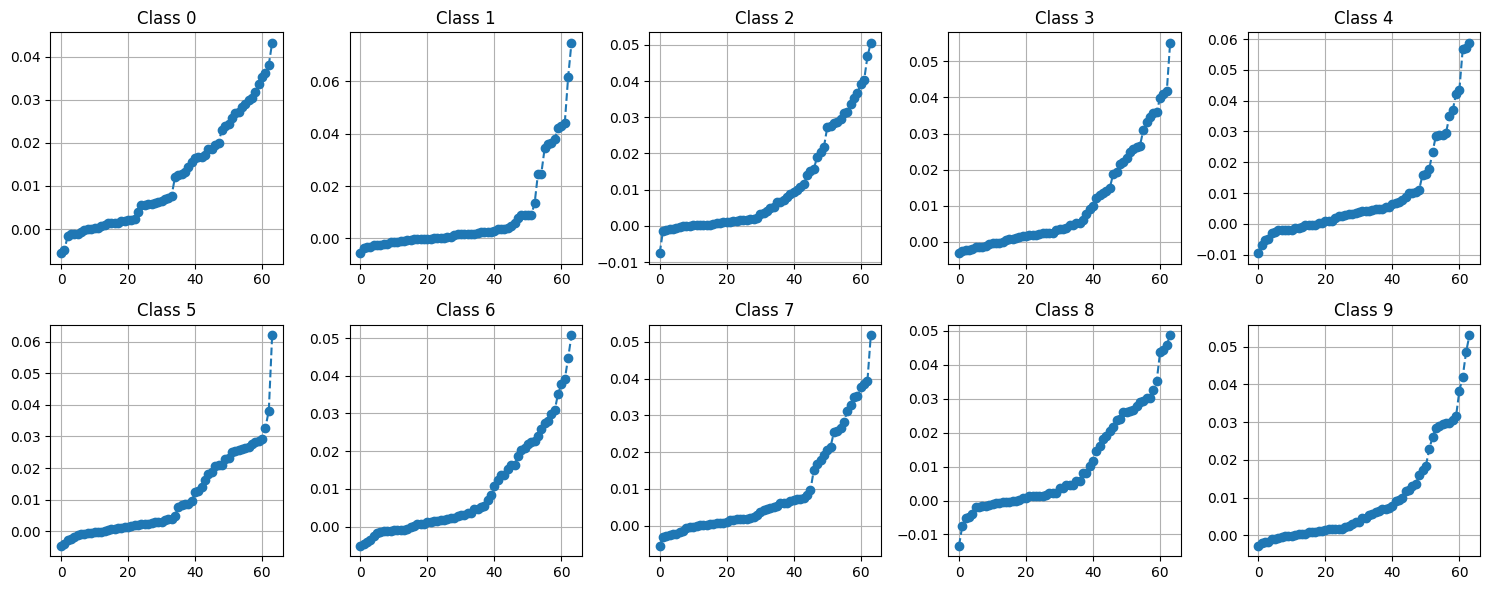

In [5]:
print("Performing inference..")
train_data = torch.as_tensor(normalized_Hermitian_Digit_matrices,dtype = torch.complex128)

train_target = [0]*100 + [1]*100 + [2]*100 + [3]*100 + [4]*100 + [5]*100 + [6]*100 + [7]*100 + [8]*100 + [9]*100

test_data = torch.as_tensor(normalized_hermitian_matrices_test_input,
                               dtype=torch.complex128)
test_target = [0]*20 + [1]*20 + [2]*20 + [3]*20 + [4]*20 + [5]*20 + [6]*20 + [7]*20 + [8]*20 + [9]*20

predicted_labels , train_acc = inference(model,train_data,torch.tensor(training_labels,dtype = torch.long))
print(f"Train Accuracy: {train_acc:.2f}%")

predicted_labels, accuracy = inference(model, test_data, torch.tensor(y_test,dtype = torch.long))
print(f"Test Accuracy: {accuracy:.2f}%")

def visualize_eigenvalues(model):
    with torch.no_grad():
        plt.figure(figsize=(15,6))
        for c in range(10):
            eig = model.eigenvalues[c].cpu().numpy()
            plt.subplot(2,5,c+1)
            plt.plot(np.sort(eig), 'o--')
            plt.title(f'Class {c}')
            plt.grid(True)
        plt.tight_layout()
        plt.show()

visualize_eigenvalues(model)